In [6]:
import adi
import numpy as np

In [7]:
sdr = adi.Pluto('ip:192.168.2.1') # адрес PlutoSDR
sdr.sample_rate = int(2.5e6)
rx_data = sdr.rx()
ifft = np.fft.ifft(rx_data)
x_real_data = []
y_imag_data = []
print("rx data length: ",len(rx_data))
print(ifft)
for i in rx_data:
    x_real_data.append(i.real)
    y_imag_data.append(i.imag)

rx data length:  1024
[ 1.265625  +4.71484375j -2.75509   -0.31301823j -0.3421256 -1.45358927j
 ... -0.3272582 -0.18260427j  0.36698242+1.20021223j
  2.06227283+3.77769544j]


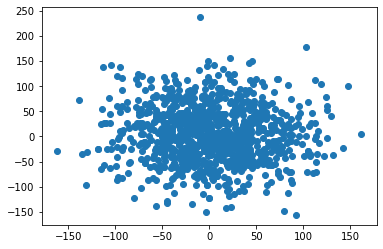

In [8]:
import matplotlib.pyplot as plt

plt.scatter(x_real_data, y_imag_data )
plt.show()

In [11]:
%matplotlib notebook

from random import randint

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# create empty lists for the x and y data
x_0 = []
y_0 = []

x_1 = []
y_1 = []

x_2 = []
y_2 = []

x_3 = []
y_3 = []

x_4 = []
y_4 = []

# create the figure and axes objects
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
x_limit = 500
y_limit = 1000
def animate(i):
    rx_data = sdr.rx()
    ifft = np.fft.ifft(rx_data)
    pt = abs(rx_data) 
    for i in range(len(rx_data)):
        x_0.append(i)
        y_0.append(abs(rx_data[i]))
        
        x_1.append(i)
        y_1.append(rx_data[i].real)
        y_2.append(rx_data[i].imag)
        
        x_3.append(rx_data[i].real)
        y_3.append(rx_data[i].imag)
        
        x_4.append(i)
        y_4.append(ifft[i])
    

    axs[0, 0].clear()
    axs[0, 0].plot(x_0, y_0)
    axs[0, 0].set_xlim([0,x_limit])
    axs[0, 0].set_ylim([-300,y_limit])
    x_0.clear()
    y_0.clear()
    
    axs[1, 0].clear()
    axs[1, 0].plot(x_1, y_1, x_1, y_2)
    axs[1, 0].set_xlim([0,x_limit])
    axs[1, 0].set_ylim([-300,y_limit])
    x_1.clear()
    y_1.clear()
    y_2.clear()
    
    axs[1, 1].clear()
    axs[1, 1].scatter(x_3, y_3, s=1)
    axs[1, 1].set_xlim([-x_limit,x_limit])
    axs[1, 1].set_ylim([-y_limit/2,y_limit/2])
    x_3.clear()
    y_3.clear()
    
    axs[0, 1].clear()
    axs[0, 1].xcorr(x_4, y_4, usevlines=True, maxlags=50, normed=True, lw=2)
    axs[0, 1].set_xlim([0,100])
    axs[0, 1].set_ylim([-1,1])
    
# run the animation
ani = FuncAnimation(fig, animate, frames=20, interval=500, repeat=True)

plt.show()

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [28]:
import adi
import numpy as np

sdr = adi.Pluto('ip:192.168.2.1')
data = [] #np.zeros((1024))
for i in range(1024):
    data.append(1000)
# Send
while(1):
    sdr.tx(data)
# Receive
#rx_data = sdr.rx()

print("tx_data: ", data)
#print("rx_data length: ", len(rx_data))
#print("rx_data: ", rx_data)

KeyboardInterrupt: 